# Data analysis of Czech Banking Dataset

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
def plotsize(x,y):
    sns.set(rc={'figure.figsize':(x,y)})

import random
from tqdm import tqdm
from datetime import datetime
import copy

from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

In [2]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.nn import BCELoss, NLLLoss, MSELoss, CrossEntropyLoss
from torch.utils.data import Dataset

In [3]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.min_rows', 100)
pd.set_option('display.max_colwidth', 400)
pd.options.display.float_format = '{:,.2f}'.format

In [4]:
%%html 
<style>.dataframe td { white-space: nowrap; } </style> 

In [5]:
def moving_average(values, window_size=30):
    cum_sum = [0]
    moving_averages = []
    for i, x in enumerate(values, 1):
        cum_sum.append(cum_sum[-1] + x)
        if i >= window_size:
            moving_avg = (cum_sum[-1] - cum_sum[-1 - window_size]) / window_size
            moving_averages.append(moving_avg)
        else:
            moving_averages.append(cum_sum[-1] / i)

    return np.array(moving_averages)

# Data preparation

## Data loading

- load data
- get only some subset
- add necessary fields
- filter only customers with enough transactions

In [12]:
pd.set_option('display.max_columns', None)

In [13]:
df = pd.read_csv('../data/czech_banking_dataset.csv', low_memory=False)

df['datetime'] = pd.to_datetime(df.date)
df = df[['trans_id', 'direction', 'type', 'client_id', 'amount', 'datetime']]
df['timestamp'] = df['datetime'].astype('datetime64[ns]').astype('int64') // 10**9

_df = df.rename(columns={'trans_id': 'id', 'client_id': 'customer.id', 'type': 'scheme'})
df = _df.groupby('customer.id').filter(lambda x: len(x) > 200)

In [14]:
print('Length of original dataframe:', len(_df))
print('Length of filtered dataframe (customers with >200 transactions):', len(df))

Length of original dataframe: 1056320
Length of filtered dataframe (customers with >200 transactions): 782366


In [15]:
grouped_df = df.groupby('customer.id')
ids = list(grouped_df.groups)
max_sequence_length = max([len(grouped_df.get_group(ids[i])) for i in range(len(grouped_df))])

In [16]:
print('Maximum sequence length:  ', max_sequence_length)
print('Total number of customers:', len(grouped_df))

Maximum sequence length:   675
Total number of customers: 2342


In [17]:
df.head()

,id,direction,scheme,customer.id,amount,datetime,timestamp
0,695247,inbound,Cash in,2873,700.00,1993-01-01,725846400
1,171812,inbound,Cash in,692,900.00,1993-01-01,725846400
2,207264,inbound,Cash in,844,"1,000.00",1993-01-01,725846400
3,1117247,inbound,Cash in,4601,600.00,1993-01-01,725846400
4,579373,inbound,Cash in,2397,400.00,1993-01-02,725932800


In [18]:
df.scheme.value_counts()

scheme
ATM withdrawal    322576
Wire              208193
Interest          131228
Cash in           114020
Card                6349
Name: count, dtype: int64

In [19]:
def convert_time_features(df):
    # Convert the date column to datetime objects
    dates = pd.to_datetime(df['datetime'])

    # Calculate the angles for each time feature
    day_of_week_angle = 2 * np.pi * dates.dt.dayofweek / 7
    day_of_month_angle = 2 * np.pi * (dates.dt.day - 1) / (dates.dt.daysinmonth - 1)
    month_angle = 2 * np.pi * (dates.dt.month - 1) / 12

    # Transform the angles into continuous features using sine and cosine functions
    day_of_week = np.column_stack((np.sin(day_of_week_angle), np.cos(day_of_week_angle)))
    day_of_month = np.column_stack((np.sin(day_of_month_angle), np.cos(day_of_month_angle)))
    month = np.column_stack((np.sin(month_angle), np.cos(month_angle)))

    # Combine the continuous features into a single numpy array
    time_features = np.hstack((day_of_week, day_of_month, month))

    return time_features

In [20]:
dates = pd.to_datetime(df['datetime'])
df['day_of_week'] = dates.dt.dayofweek
df['day_of_month'] = dates.dt.day
df['month'] = dates.dt.month

In [21]:
df.head()

,id,direction,scheme,customer.id,amount,datetime,timestamp,day_of_week,day_of_month,month
0,695247,inbound,Cash in,2873,700.00,1993-01-01,725846400,4,1,1
1,171812,inbound,Cash in,692,900.00,1993-01-01,725846400,4,1,1
2,207264,inbound,Cash in,844,"1,000.00",1993-01-01,725846400,4,1,1
3,1117247,inbound,Cash in,4601,600.00,1993-01-01,725846400,4,1,1
4,579373,inbound,Cash in,2397,400.00,1993-01-02,725932800,5,2,1


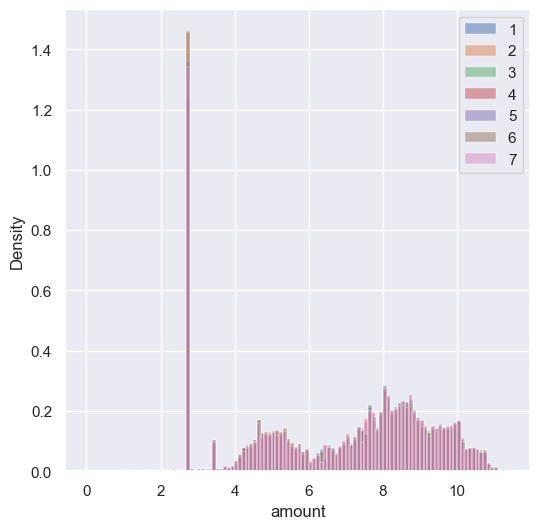

In [44]:
gdf = df.groupby('day_of_week')

plotsize(6,6)
for day, g in gdf:
    sns.histplot(np.log(1 + g.amount), stat='density', label=day + 1, alpha=0.5, binwidth=0.1)

plt.legend()
plt.show()

In [46]:
df.day_of_month.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
      dtype=int32)

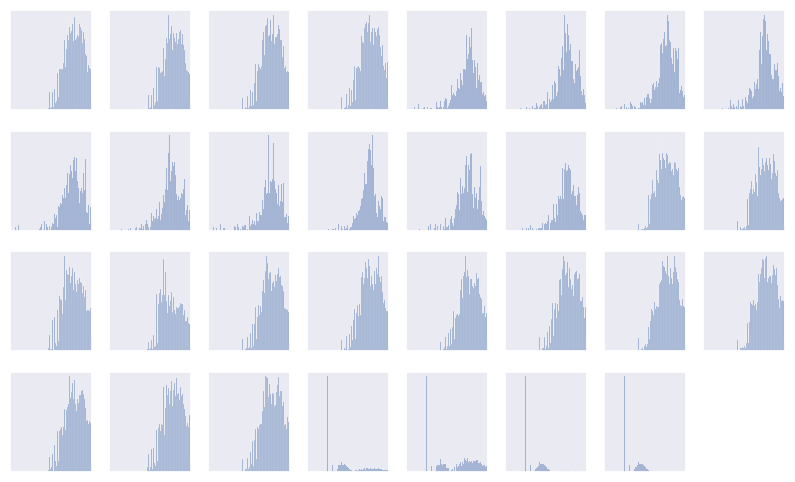

In [51]:
gdf = df.groupby('day_of_month')

plotsize(10,6)
for day, g in gdf:
    plt.subplot(4,8,day)
    sns.histplot(np.log(1 + g.amount), stat='density', label=day + 1, alpha=0.5, binwidth=0.1)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')
    plt.xlim(0,11)

plt.show()

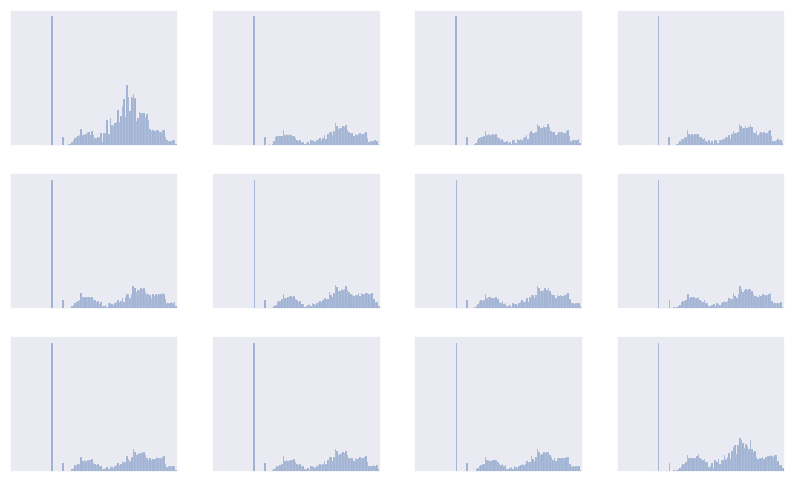

In [52]:
gdf = df.groupby('month')

plotsize(10,6)
for day, g in gdf:
    plt.subplot(3,4,day)
    sns.histplot(np.log(1 + g.amount), stat='density', label=day + 1, alpha=0.5, binwidth=0.1)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')
    plt.xlim(0,11)

plt.show()

In [76]:
df['week'] = df['datetime'].dt.strftime('%Y-%m-%d') + '-' + df['datetime'].dt.strftime('%Y-%U-%w')
df['month'] = df['datetime'].dt.strftime('%Y-%m')
df.head()

,id,direction,scheme,customer.id,amount,datetime,timestamp,day_of_week,day_of_month,month,week
0,695247,inbound,Cash in,2873,700.00,1993-01-01,725846400,4,1,1993-01,1993-01-01-1993-00-5
1,171812,inbound,Cash in,692,900.00,1993-01-01,725846400,4,1,1993-01,1993-01-01-1993-00-5
2,207264,inbound,Cash in,844,"1,000.00",1993-01-01,725846400,4,1,1993-01,1993-01-01-1993-00-5
3,1117247,inbound,Cash in,4601,600.00,1993-01-01,725846400,4,1,1993-01,1993-01-01-1993-00-5
4,579373,inbound,Cash in,2397,400.00,1993-01-02,725932800,5,2,1993-01,1993-01-02-1993-00-6


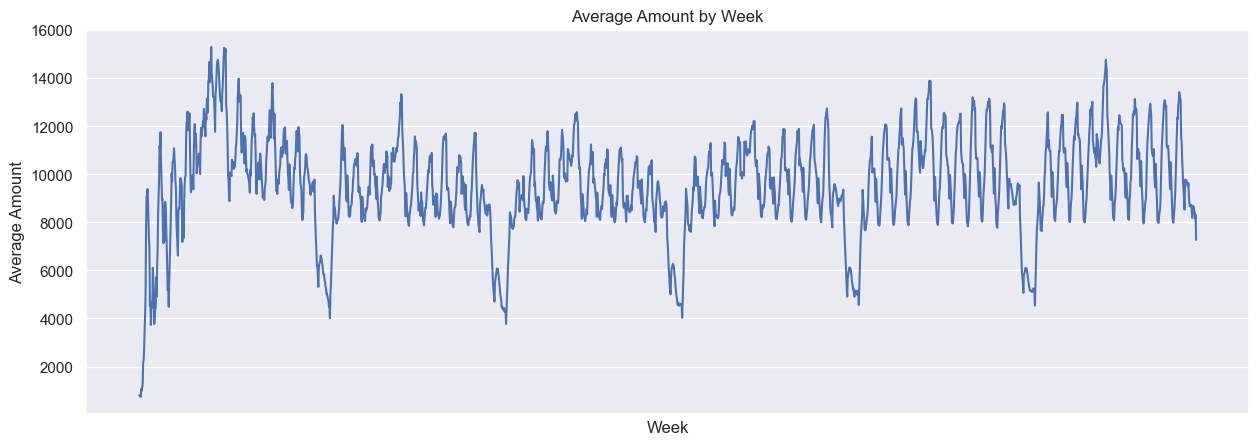

In [86]:
# Group the data by day and calculate the mean amount
# grouped = df.groupby('week')['amount'].mean()
group_column = 'week'
grouped = df.groupby(group_column)['amount'].mean()

# Create a line plot of the mean amount by day
# grouped.plot(kind='line', figsize=(10, 6))
plotsize(15,5)
sns.lineplot(x=np.array(grouped.index), y=moving_average(grouped.values, 8))

# Add labels and title to the plot
plt.xlabel(group_column.capitalize())
# plt.xticks(rotation=90)
plt.xticks([])
plt.ylabel('Average Amount')
plt.title(f'Average Amount by {group_column.capitalize()}')

# Show the plot
plt.show()